# **Multi-Class Prediction of Cirrhosis Outcomes**

## **2023 Kaggle Playground Series Session 3 Episode26**
https://www.kaggle.com/competitions/playground-series-s3e26

## **Mission : 간경변증 환자 생존 확률 예측**

### **평가지표: logloss**
#### $$ logloss = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{i,j} \log_{} (p_{i,j})  $$

#### $$ N \ : \ the \ number \ of \ rows \ in \ the \ test \ set $$

#### $$ M \ : \ the \ number \ of \ outcomes $$

#### $$ In \ order \ to \ avoid \ the \ extremes \ of \ the \ log \ function, \ predicted \ probabilities \ are \ replaced \ with $$

#### $$ max\left(min\left(p, 1-10^{-15}\right), 10^{-15} \right) $$

### **문제유형: 다중분류**

#### **사용 모델 : XGBoost LightGBM Catboost Ensemble Model**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

!pip3 install xgboost
!pip3 install lightgbm
!pip install catboost

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

!pip install optuna 
import optuna

In [2]:
train = pd.read_csv("train.csv").drop(columns=['id'], axis=1)
test = pd.read_csv('test.csv').drop(columns=['id'], axis=1)
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float64
 18  Status  

In [5]:
test.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5271 non-null   int64  
 1   Drug           5271 non-null   object 
 2   Age            5271 non-null   int64  
 3   Sex            5271 non-null   object 
 4   Ascites        5271 non-null   object 
 5   Hepatomegaly   5271 non-null   object 
 6   Spiders        5271 non-null   object 
 7   Edema          5271 non-null   object 
 8   Bilirubin      5271 non-null   float64
 9   Cholesterol    5271 non-null   float64
 10  Albumin        5271 non-null   float64
 11  Copper         5271 non-null   float64
 12  Alk_Phos       5271 non-null   float64
 13  SGOT           5271 non-null   float64
 14  Tryglicerides  5271 non-null   float64
 15  Platelets      5271 non-null   float64
 16  Prothrombin    5271 non-null   float64
 17  Stage          5271 non-null   float64
dtypes: float

submission.info()

## **feature 알아보기**

- 01. id
    - 환자 번호(unique identifier)
    - 인덱스 번호와 동일하므로 drop
    - type : int64
  

- 02. N_Days
    - 1986년 7월 이전 사망, 이식, 연구 분석 사건까지의 일수   
    - type : int64

- 03. Drug
    - 투여한 약의 종류               
    - type : object 

- 04. Age  : 나이(단위 : 일)
    - type : int64  

- 05. Sex : 성별         
    - type : object 

- 06. Ascites : 환자의 복수 여부
    - 복수란 배속의 공간복강의 액체가 차는 것을 말한다.  
    - type : object

- 07. Hepatomegaly : 간비대 존재 여부, 간비대란 간이 커지는 것을 말한다. 
    - 주요 원인은 간염, 간 종양 등 다양한 원인으로 간 조직이 파괴되면서 손상된 간 기능을 회복하기 위한 보상 반응으로 생성
    - type : object 

- 08. Spiders : 거미양 혈관종 존재여부
    - spider angioma라고 부르며 가는 모세혈관이 확장되는 것을 말한다. 주요 원인은 호르몬, 남성보다는 여성에게 흔하게 나타남
    - type : object 

- 09. Edema : 부종 여부     
    - 부종이란 우리 몸의 세포 사이 조직이나 순환계에 비정상적으로 액체가 과하게 있는 상태
    - type : object

- 10. Bilirubin : 혈청 빌리루빈 수치 (단위 : mg/dl)
    - 빌리루빈은 적혈구가 파괴될 때 헤모글로빈이 분해되어 생기는 노란색 색소
    - 혈액의 빌리루빈 농도가 증가하면 간 문제를 발생시키고 황달이 생길 수 있다. 정상치는 총빌리루빈 : 0.2~1.0 ㎎/㎗
    - type : float64

- 11. Cholesterol : 혈중 콜레스테롤 수치  (단위 : mg/dl)
    - 혈중 콜레스테롤 수치가 높을수록 간 건강에 좋지 않다.
    - type : float64

- 12. Albumin : 알부민 수치 (단위 : gm/dl)
    - 알부민이란 세포의 기본 물질을 구성하는 단백질의 하나로 혈관속에서 체액이 머물게 하여 혈관과 조직 사이의 삼투압 유지에 중요한 역할
    - 간 기능 손상 시 알부민 생산이 감소된다.
    - 알부민 농도 증가시 간경화가 나타날 수 있다. 알부민은 전적으로 간에서만 합성된다. 정상범위는 3.5~5.2 g/dL
    - type : float64

- 13. Copper : 소변 내 구리 양 (단위 : ug/day)        
    - 정상 범위 : 시간당 10~30 마이크로그램
    - Copper 수치가 정상보다 높으면 간경변 발생할 수 있다.
    - type : float64

- 14. Alk_Phos : 간 기능 검사 ALP수치 (단위 : U/liter)
    - ALT 수치 증가 시 간 기능 문제 발생, 정상치 남 40 ~ 129(U/L) 여 35 ~ 104(U/L)
    - type : float64

- 15. SGOT : 간 기능 검사 AST 수치 (단위 U/ml)
    - AST 수치 증가 시 간 기능 문제 발생, 정상치 0~40 IU/L
    - type : float64

- 16. Tryglicerides : 중성 지방 수치
    - Tryglicerides 수치 증가 시, 동맥 경화 유발
    - type : float64

- 17. Platelets  : 혈소판 수치 (단위 ml/1000)
    - 혈소판 수치 이상 시 간 부전 발생, 정상범위는 150,000-450,000/uL 
    - type : float64

- 18. Prothrombin : 프로트롬빈 수치(혈액 응고 시간 검사)
    - 프로트롬빈, 혈액에 함유된 혈액응고 인자의 하나로 출혈을 멎게 하는 단백질, 정상범위 11.4~15.4초
    - type : float64

- 19. Stage : 질병의 조직학적 단계     
    - type : float64


- 20. Status : 환자 상태, target value
    - type : object

## 피쳐 요약표 만들기

In [7]:
def resumetable(df):
  print(f'데이터셋 형상: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
  summary = summary.reset_index()
  summary = summary.rename(columns={'index': '피처 값'})
  summary['결측값 개수'] = df.isnull().sum().values
  summary['고윳값 개수'] = df.nunique().values
  summary['첫 번째 값'] = df.loc[0].values
  summary['두 번째 값'] = df.loc[1].values
  return summary

summary1 = resumetable(train)
summary2 = resumetable(test)

데이터셋 형상: (7905, 19)
데이터셋 형상: (5271, 18)


In [8]:
summary1
# train 데이터에는 결측값이 없다.

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,N_Days,int64,0,461,999,2574
1,Drug,object,0,2,D-penicillamine,Placebo
2,Age,int64,0,391,21532,19237
3,Sex,object,0,2,M,F
4,Ascites,object,0,2,N,N
5,Hepatomegaly,object,0,2,N,N
6,Spiders,object,0,2,N,N
7,Edema,object,0,3,N,N
8,Bilirubin,float64,0,111,2.3,0.9
9,Cholesterol,float64,0,226,316.0,364.0


In [9]:
summary2
# test 데이터에는 결측값이 없다.

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,N_Days,int64,0,409,3839,2468
1,Drug,object,0,2,D-penicillamine,D-penicillamine
2,Age,int64,0,363,19724,14975
3,Sex,object,0,2,F,F
4,Ascites,object,0,2,N,N
5,Hepatomegaly,object,0,2,Y,N
6,Spiders,object,0,2,N,N
7,Edema,object,0,3,N,N
8,Bilirubin,float64,0,108,1.2,1.1
9,Cholesterol,float64,0,222,546.0,660.0


In [10]:
# 이진형 변수 수치형 변수와 범주형 변수 분리

# 이진형 변수
# ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders']
bin_cols = summary1[summary1['고윳값 개수'] == 2]['피처 값'].values

# 순서형 변수 & 명목형 변수
# ['Edema', 'Stage']
ord_cols = ['Edema','Stage']

# .연속형 변수
# ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
#   'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
con_cols = summary1[summary1['고윳값 개수'] > 4]['피처 값'].values

## **EDA**

In [11]:
def write_percent(ax, total_size):
# 도향 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시
  for patch in ax.patches:
    height = patch.get_height()       # 도형 높이(데이터 개수)
    width = patch.get_width()         # 도형 너비
    left_coord = patch.get_x()        # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size*100   # 타깃값 비율

    # (x, y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,      # x축 위치
            height + total_size *0.001,  # y축 위치
            '{:1.1f}%'.format(percent),  # 입력 텍스트
             ha='center')                # 가운데 정렬

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

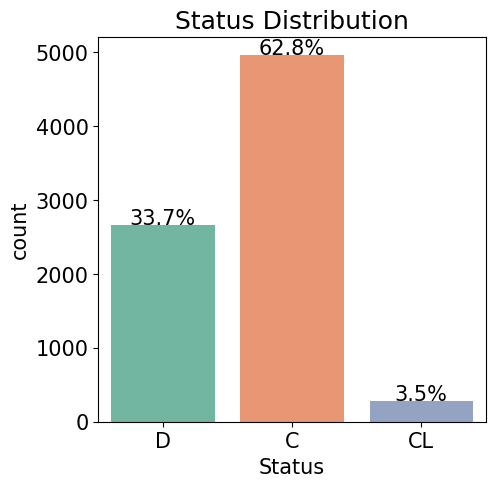

In [12]:
# 타깃값 분포
mpl.rc('font', size=15)
plt.figure(figsize=(5,5))

ax = sns.countplot(x='Status', data=train, palette='Set2')
write_percent(ax, len(train))
ax.set_title('Status Distribution')

train['Status'].value_counts()
# C : 생존
# D : 사망
# CL : 간 이식 후 생존 -> 매우 적음

In [13]:
# 이진 피처
print(train['Drug'].value_counts())
print()

print(train['Sex'].value_counts())
print()

print(train['Ascites'].value_counts())
print()

print(train['Hepatomegaly'].value_counts())
print()

print(train['Spiders'].value_counts())

Drug
Placebo            4010
D-penicillamine    3895
Name: count, dtype: int64

Sex
F    7336
M     569
Name: count, dtype: int64

Ascites
N    7525
Y     380
Name: count, dtype: int64

Hepatomegaly
Y    4042
N    3863
Name: count, dtype: int64

Spiders
N    5966
Y    1939
Name: count, dtype: int64


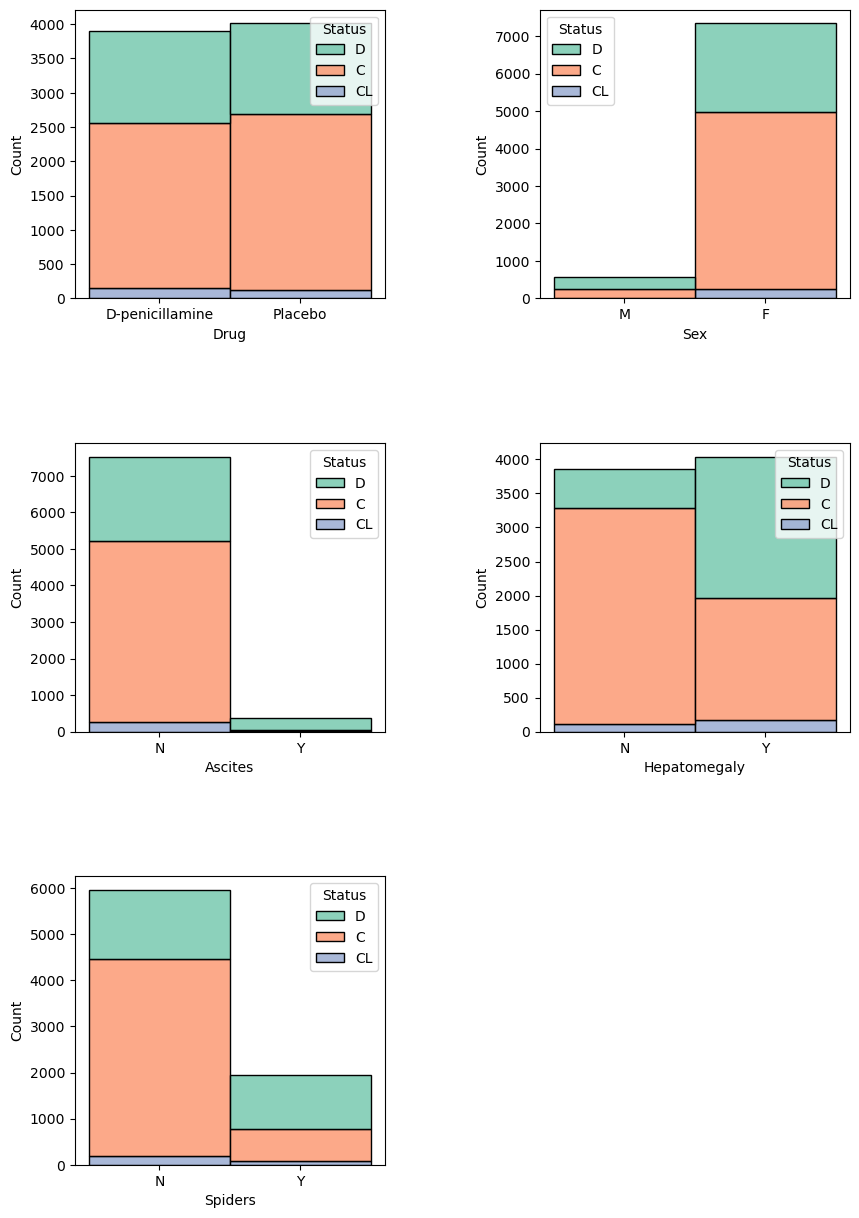

In [63]:
# 이진 피처의 고윳값별 타깃값 비율
def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12,8), kde=False, multiple='stack'):
  mpl.rc('font', size=10)
  plt.figure(figsize=size)
  grid = gridspec.GridSpec(num_rows, num_cols)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

  for idx, feature in enumerate(features):
    ax = plt.subplot(grid[idx])
    sns.histplot(x=feature, hue='Status', data=train, palette='Set2', ax=ax, multiple=multiple, kde=kde)

plot_target_ratio_by_features(train, bin_cols, 3, 2, (10, 15))

In [15]:
# 순서 피처
print(train['Stage'].value_counts())
print()

# 명목 피처
print(train['Edema'].value_counts())

Stage
3.0    3153
4.0    2703
2.0    1652
1.0     397
Name: count, dtype: int64

Edema
N    7161
S     399
Y     345
Name: count, dtype: int64


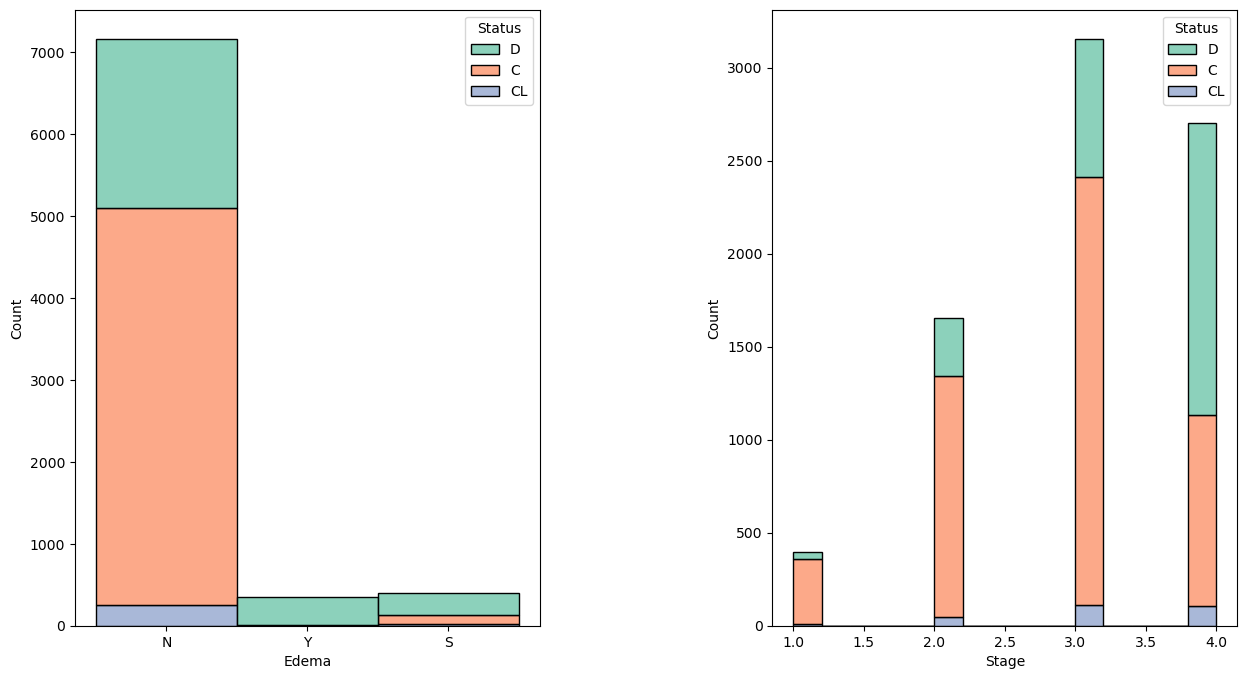

In [64]:
# 순서형 변수 & 명목형 변수
plot_target_ratio_by_features(train, ord_cols, 1, 2, (15, 8))

In [65]:
# 연속형 피쳐 고윳값별 타깃값 비율 (histogram)

def plot_target_ratio_by_features_cons(df, features, num_rows, num_cols, size=(12,8), kde=False, multiple='stack', bins=None):
  mpl.rc('font', size=15)
  plt.figure(figsize=size)
  grid = gridspec.GridSpec(num_rows, num_cols)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

  for idx, feature in enumerate(features):
    ax = plt.subplot(grid[idx])
    sns.histplot(x=feature, hue='Status', data=train, palette='Set2', ax=ax, multiple=multiple, kde=kde, bins=bins)

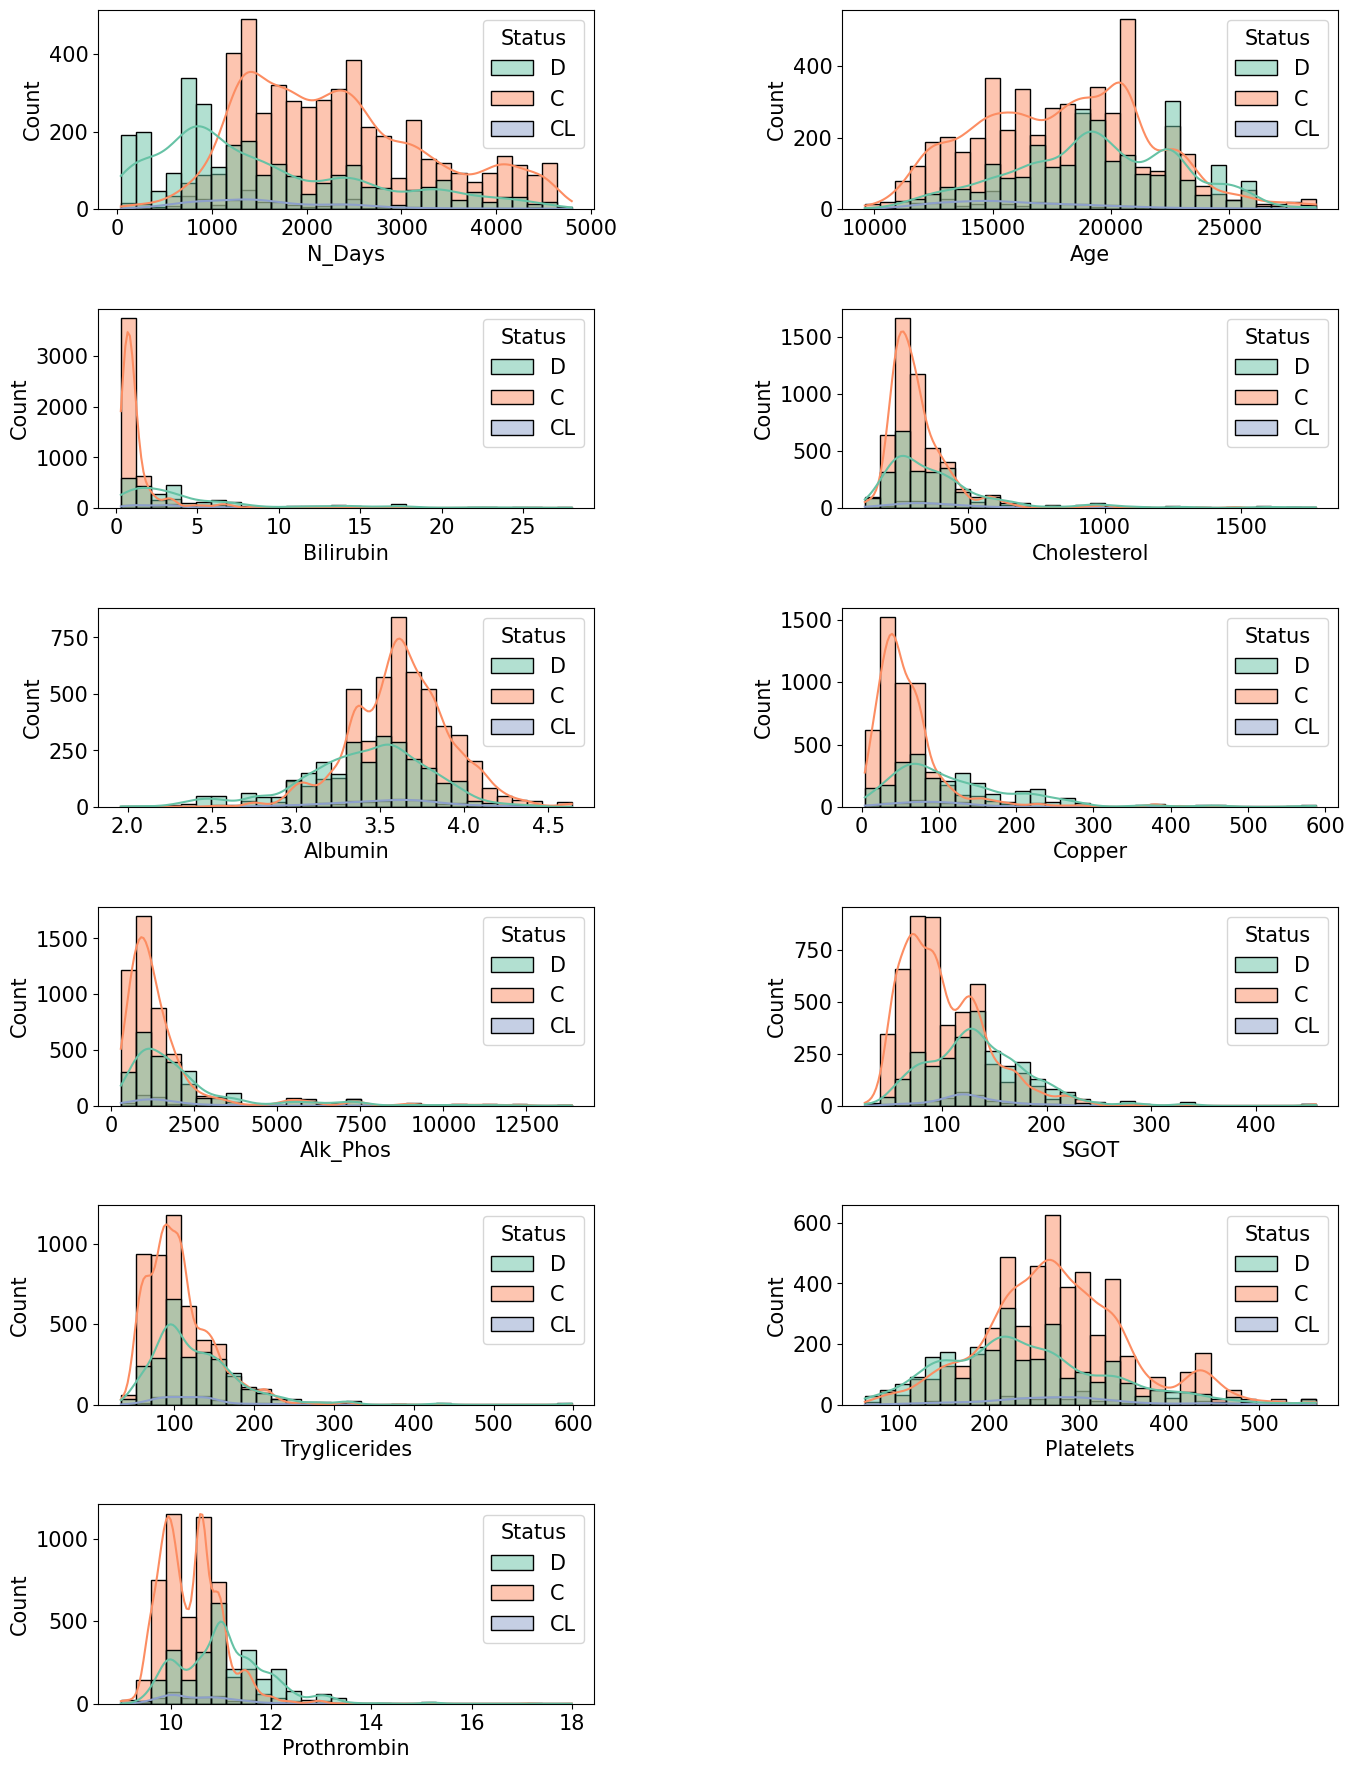

In [66]:
# 연속형 피쳐 (histogram)
plot_target_ratio_by_features_cons(train, con_cols, 6, 2, (16, 22), multiple='layer', kde=True, bins=30)

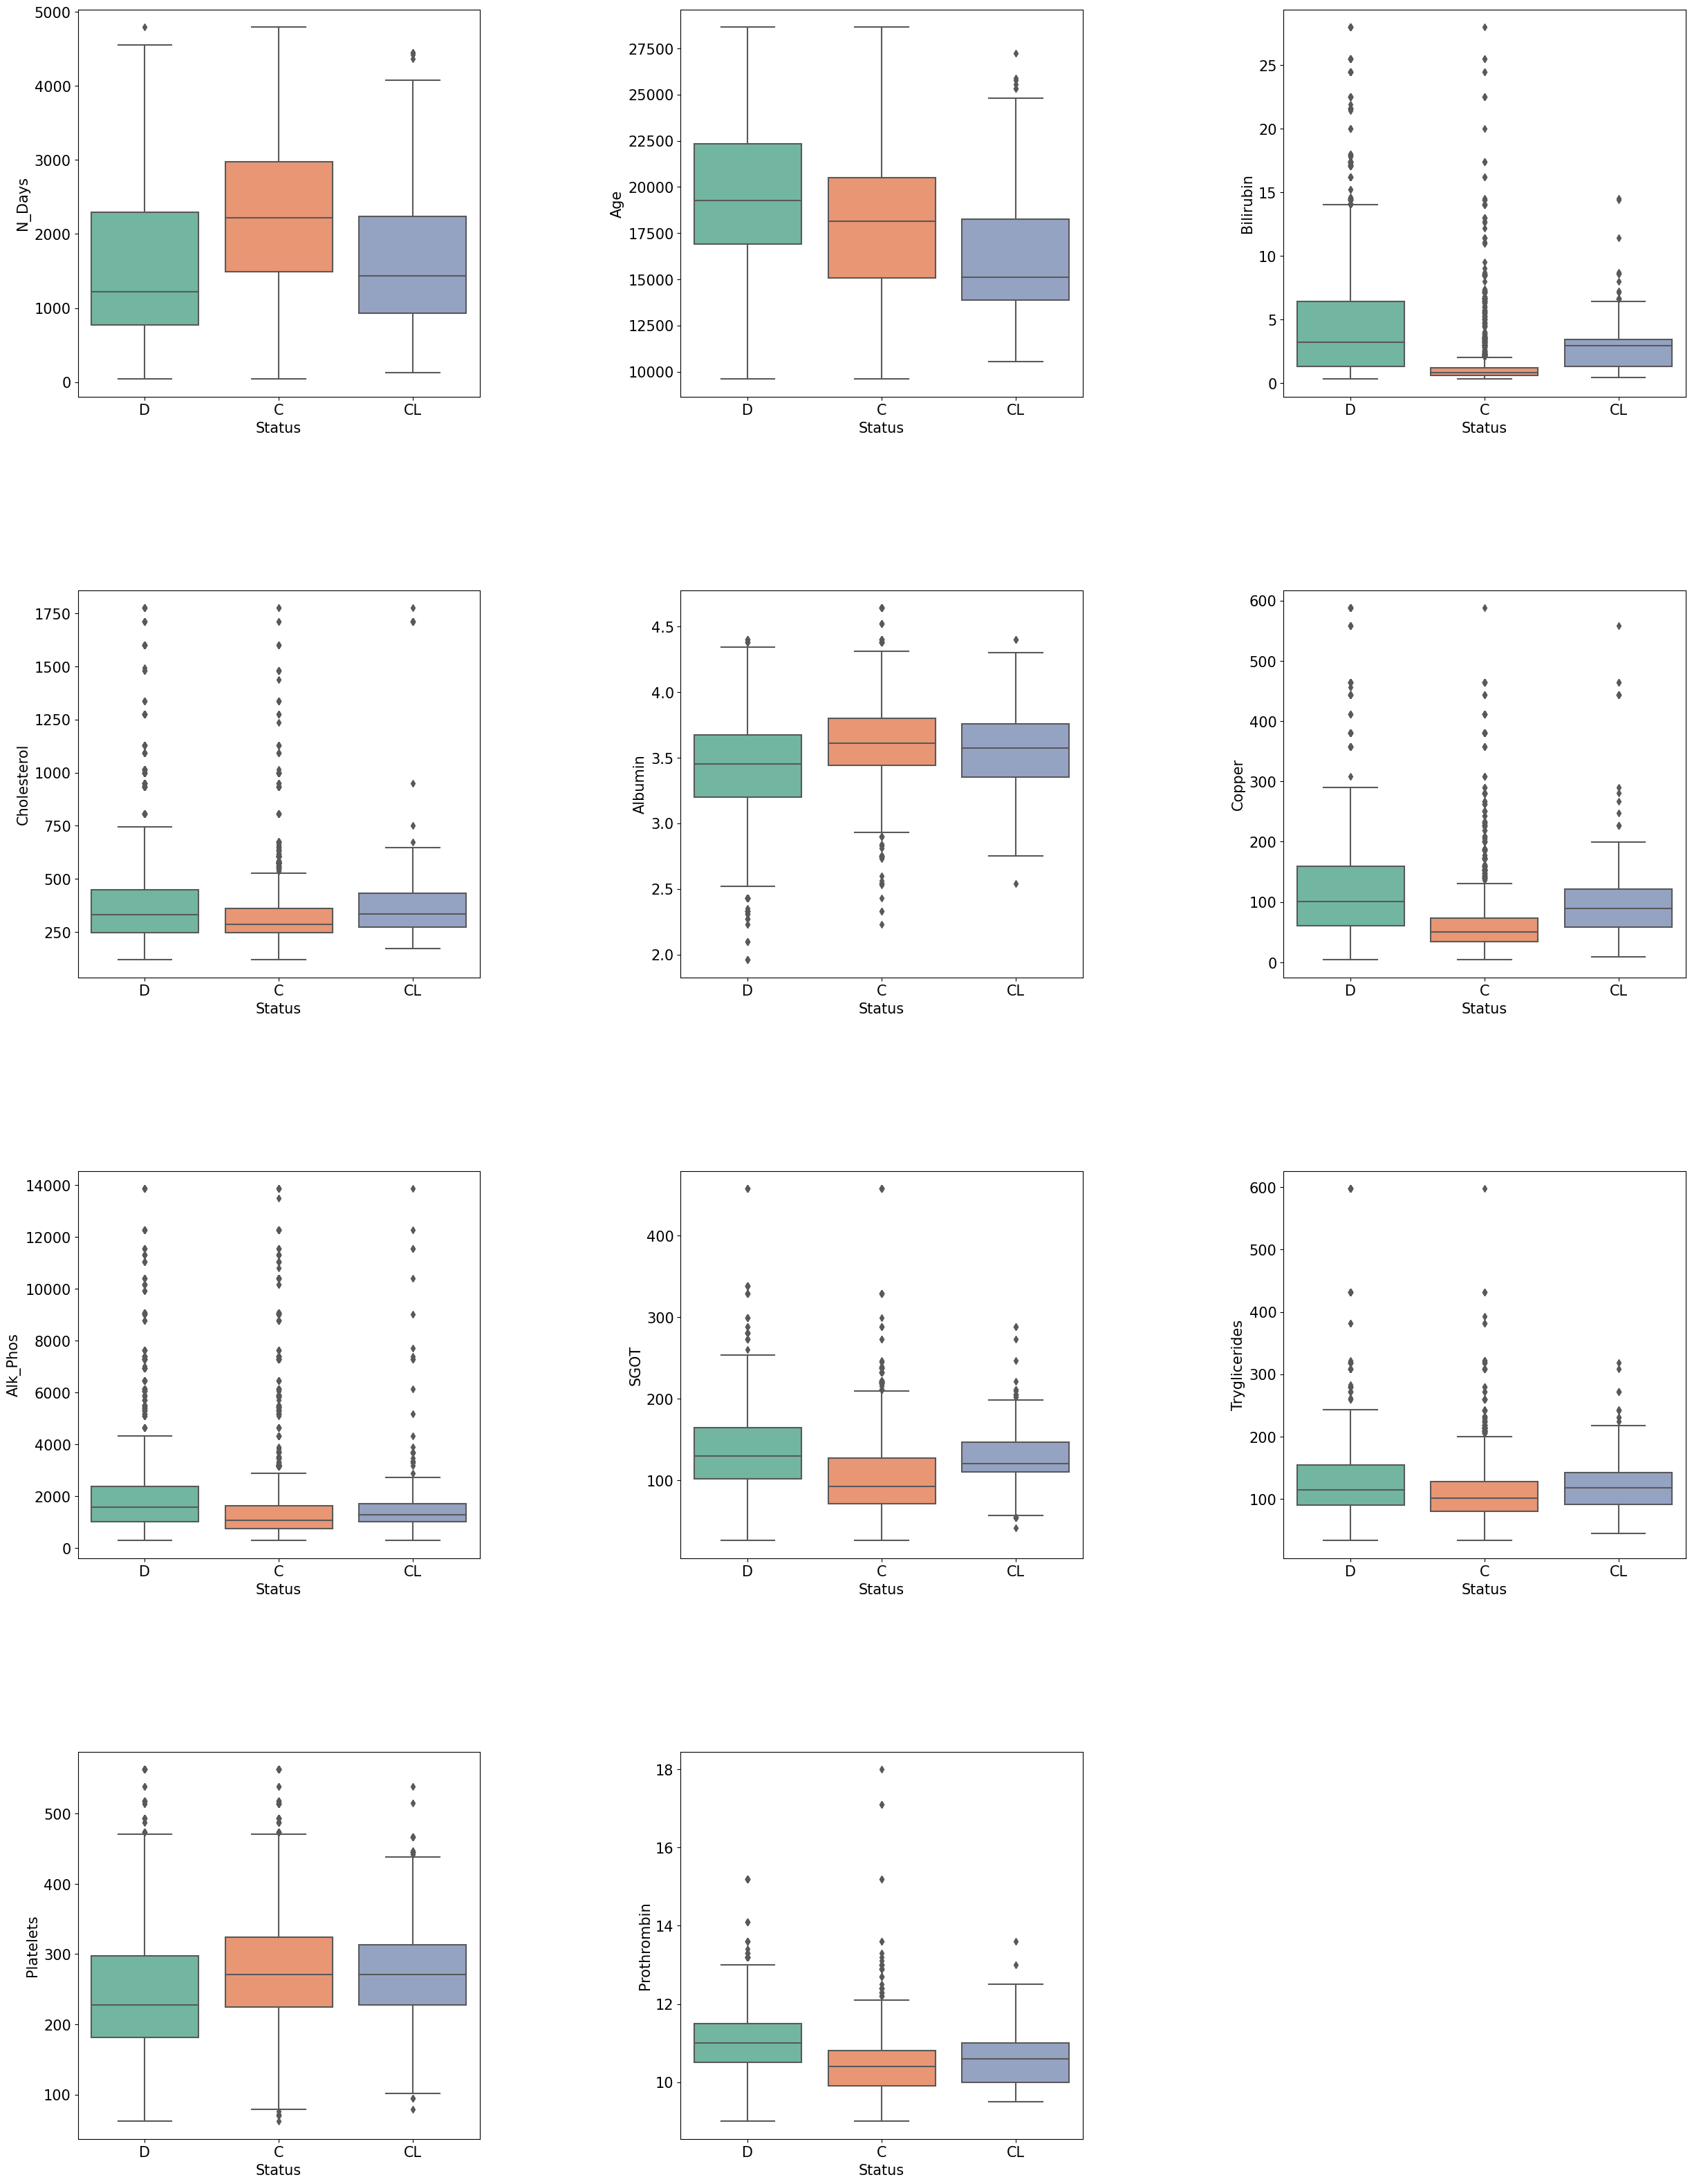

In [67]:
# 연속형 피쳐 고윳값별 타깃값 비율 (boxplot)

def plot_target_ratio_by_features_boxplot(df, features, num_rows, num_cols, size=(12,8)):
  mpl.rc('font', size=15)
  plt.figure(figsize=size)
  grid = gridspec.GridSpec(num_rows, num_cols)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

  for idx, feature in enumerate(features):
    ax = plt.subplot(grid[idx])
    sns.boxplot(x='Status', y=feature, data=train, palette='Set2', ax=ax)

plot_target_ratio_by_features_boxplot(train, con_cols, 4, 3, (30, 40))

# 이상치들이 꽤 존재

<Axes: >

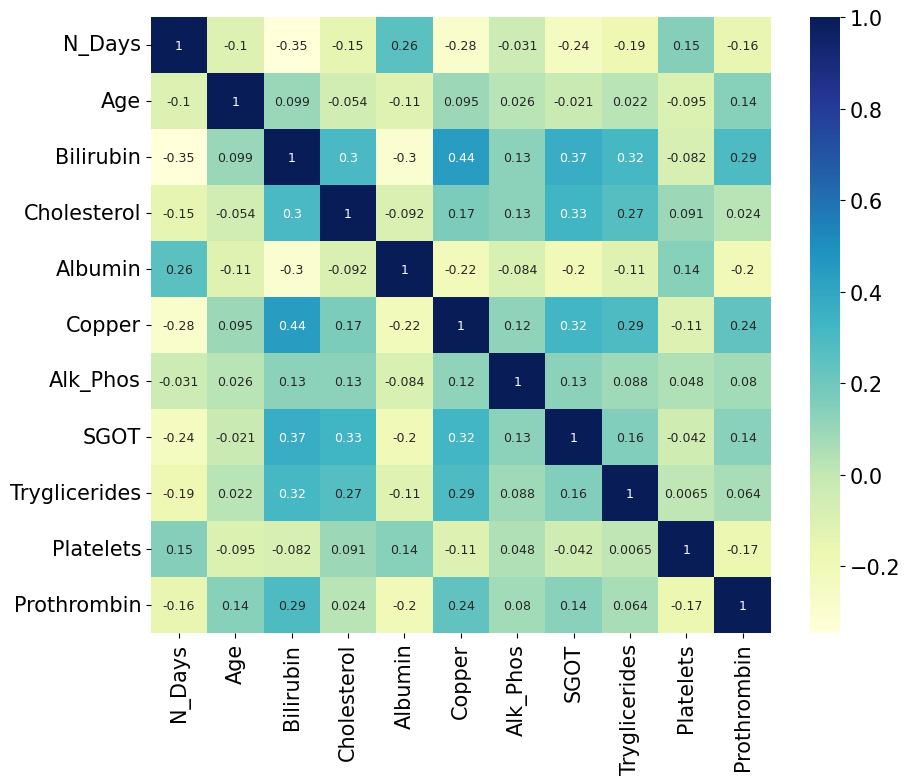

In [49]:
# 연속형 피쳐 heatmap

plt.figure(figsize=(10,8))
cont_corr = train[con_cols].corr()
sns.heatmap(cont_corr, annot=True, cmap='YlGnBu', annot_kws={"size" : 9})

# 상관관계가 강한 피처는 없으므로 연속형 변수 중 삭제 할 피쳐는 없음.

## **Feature 분석 정리**

### **이진형 변수**

- 공통 특징 : One-Hot-Encoding 대상
- Drug
    - 약의 종류 : D-penicillamine, Drug_Placebo
    - type : object
- Sex
    - 성별 종류 : M(남성), F(여성)
    - 환자 및 간 이식 비율이 여성이 높음
    - type : object
- Ascites
    - 복수 여부 : N / Y
    - 복수가 없는 환자의 비율 및 간 이식 비율이 높음
    - type : object
- Hepatomegaly
    - 간 비대 존재 여부 : N / Y
    - 간 비대가 존재하는 환자 중 사망 환자가 많다.
    - type : object   : - Spider
    - 거미양 혈관종 존재 여부 : N / Y
    - Spiders가 있는 환자의 비율이 없는 환자보다 약 3배 많다.
    - 간 이식 환자 중 Spiders가 없는 환자 비율이 조금 높다.
    - type : object:

- **주요 결론**<br>
-> 이진형 변수는 모두 One-Hot-Encoding의 대상이며, Sex, Ascites Spiders 피쳐에서 데이터 불균형이 보인다. 

### **명목형 변수**
- 특징 : One-Hot-Encoding 대상
- Edema
    - 부정 여부 종류 : N, Y, S
    - N : 부종 X, 이뇨제 치료 진행 X
    - Y : 이뇨제 치료법에도 불구하고 부종 O
    - S : 이뇨제 없이 발현된 부종 or 이뇨제에 의해 해결 되는 부종
    - 부종이 없는 환자가 많다.
    - 부종이 없는 환자 중 간 이식 환자 다수 존재
    - type : object

- **주요 결론**
-> 명목형 변수는 One-Hot-Encoding의 대상

### **순서형 변수**
- 특징 : One-Hot-Encoding 대상
- 1. Stage 
    - 질병의 조직화 단계 : 1, 2, 3, 4단계
    - 간 이식 환자는 주로 2단계부터 존재
    - 단계가 증가할수록 사망 환자도 증가
    - type : float64<br>

- **주요 결론**<br>
-> 순서형 변수는 One-Hot-Encoding의 대상 

### **연속형 변수**
- 특징: 데이터 한 쪽으로 치우쳐진 분포 존재 및 이상치 존재 -> 이상치 제거 및 정규화 대상
- N_Days
- Age
  - 주로 40세 이상에서 Liver Cirrhosis 발생
    - 간 이식은 주로 50세 이전에 많이 받는다.
    - 고연령층에서 사망 환자가 많다.
- Bilirubin
  - 일반적으로 빌리루빈 수치가 높으면 Liver Cirrhosis 발생 확률이 높지만, 현재 데이터로는 크게 이상 수치가 보이지 않는다.
- Cholesterol
  - 중성지방 수치는 D와 CL의 중앙값이 C보다 높다. -> 중성지방 수치가 높을수록 Liver Cirrhosis 발생 확률이 높다.
- Albumin
- Copper
- Alk_Phos
  - ALT 수치는 D와 CL의 중앙값이 C보다 높다. -> ALT 수치가 높을수록 Liver Cirrhosis 발생 확률이 높다.
- SGOT
  - AST 수치는 D와 CL의 중앙값이 C보다 높다. -> AST 수치가 높을수록 Liver Cirrhosis 발생 확률이 높다.
- Tryglicerides
- Platelets
  - 혈소판 수치는 D가 C보다 적다. -> 혈소판 수치가 낮을수록 Liver Cirrhosis 발생 확률이 높다.
- Prothrombin

- **주요 결론**<br>
-> 연속형 변수는 Scaling의 대상 

## **Feature Engineering**

- 이진, 명목, 순서 피쳐의 One-Hot-Encoding
- MinMaxScaler을 통한 정규화 실시

In [21]:
train = pd.read_csv('train.csv').drop(columns=['id'], axis=1)
test = pd.read_csv('test.csv').drop(columns=['id'], axis=1)
submission = pd.read_csv('sample_submission.csv')

In [22]:
# 이진, 명목, 순서 피쳐의 One-Hot-Encoding

oht_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
train_oht = pd.get_dummies(train, columns=oht_cols, dtype=int)
test_oht = pd.get_dummies(test, columns=oht_cols, dtype=int)
# 모든 데이터의 값을 수치형으로 변경

# oht열만 추출
train_oht = train_oht[['Drug_D-penicillamine', 'Drug_Placebo',
                        'Sex_F', 'Sex_M',
                        'Ascites_N', 'Ascites_Y',
                        'Hepatomegaly_N', 'Hepatomegaly_Y',
                        'Spiders_N', 'Spiders_Y',
                        'Edema_N', 'Edema_S', 'Edema_Y',
                        'Stage_1.0', 'Stage_2.0', 'Stage_3.0', 'Stage_4.0']]

test_oht = test_oht[['Drug_D-penicillamine', 'Drug_Placebo',
                     'Sex_F', 'Sex_M',
                     'Ascites_N', 'Ascites_Y',
                     'Hepatomegaly_N', 'Hepatomegaly_Y',
                     'Spiders_N', 'Spiders_Y',
                     'Edema_N', 'Edema_S', 'Edema_Y',
                     'Stage_1.0', 'Stage_2.0', 'Stage_3.0', 'Stage_4.0']]

In [23]:
train_oht.head()

,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0
1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
2,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1
3,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
4,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1


In [24]:
test_oht.head()

,Drug_D-penicillamine,Drug_Placebo,Sex_F,Sex_M,Ascites_N,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0
1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0
2,0,1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,1
3,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0
4,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0


In [25]:
# MinMaxScaler을 통한 정규화 실시
# 기타 RobustScaler, PowerTransformer 보다 MinMaxScaler가 근소하게 뛰어난 성능을 보임

In [26]:
'''
# RobustScaler
from sklearn.preprocessing import RobustScaler

rs= RobustScaler()

# 표준 정규화할 변수들 = 연속형 변수들 con_cols 
# 연속형 변수들이 대부분 한쪽으로 치우쳐저 있음
train_to_scale = train[con_cols]
test_to_scale = test[con_cols]
scaled_train = pd.DataFrame(rs.fit_transform(train_to_scale), columns = train_to_scale.columns)
scaled_test = pd.DataFrame(rs.transform(test_to_scale), columns = test_to_scale.columns)

# 주의 ) test data에는 fit_transform x, transform만 적용
'''


'\n# RobustScaler\nfrom sklearn.preprocessing import RobustScaler\n\nrs= RobustScaler()\n\n# 표준 정규화할 변수들 = 연속형 변수들 con_cols \n# 연속형 변수들이 대부분 한쪽으로 치우쳐저 있음\ntrain_to_scale = train[con_cols]\ntest_to_scale = test[con_cols]\nscaled_train = pd.DataFrame(rs.fit_transform(train_to_scale), columns = train_to_scale.columns)\nscaled_test = pd.DataFrame(rs.transform(test_to_scale), columns = test_to_scale.columns)\n\n# 주의 ) test data에는 fit_transform x, transform만 적용\n'

In [27]:
# MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

train_to_scale = train[con_cols]
test_to_scale = test[con_cols]

scaled_train = pd.DataFrame(ms.fit_transform(train_to_scale), columns = train_to_scale.columns)
scaled_test = pd.DataFrame(ms.transform(test_to_scale), columns = test_to_scale.columns)
# 주의) test data에는 fit_transform이 아닌 transform을 적용한다.

In [28]:
'''
# PowerTransformer
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method = 'yeo-johnson')

train_to_scale = train[con_cols]
test_to_scale = test[con_cols]

scaled_train = pd.DataFrame(transformer.fit_transform(train_to_scale), columns = train_to_scale.columns)
scaled_test = pd.DataFrame(transformer.transform(test_to_scale), columns = test_to_scale.columns)
'''

"\n# PowerTransformer\nfrom sklearn.preprocessing import PowerTransformer\n\ntransformer = PowerTransformer(method = 'yeo-johnson')\n\ntrain_to_scale = train[con_cols]\ntest_to_scale = test[con_cols]\n\nscaled_train = pd.DataFrame(transformer.fit_transform(train_to_scale), columns = train_to_scale.columns)\nscaled_test = pd.DataFrame(transformer.transform(test_to_scale), columns = test_to_scale.columns)\n"

In [29]:
# One-Hot-Encoding열과 MinMaxScaler열을 합쳐 train_data와 test_data 생성

train_data = pd.concat([scaled_train, train_oht], axis=1)
test_data = pd.concat([scaled_test, test_oht], axis=1)

In [30]:
train_data.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,0.201515,0.626391,0.072202,0.118429,0.518657,0.287671,0.096660,0.356115,0.053097,0.662675,...,0,1,0,1,0,0,0,0,1,0
1,0.532814,0.505931,0.021661,0.147432,0.589552,0.101027,0.084798,0.251799,0.097345,0.596806,...,0,1,0,1,0,0,0,0,1,0
2,0.712453,0.216723,0.108303,0.108157,0.593284,0.217466,0.054518,0.215827,0.030088,0.273453,...,1,0,1,0,0,1,0,0,0,1
3,0.533235,0.465148,0.010830,0.082175,0.574627,0.092466,0.100491,0.104317,0.111504,0.413174,...,0,1,0,1,0,0,0,0,1,0
4,0.157131,0.370565,0.028881,0.136556,0.630597,0.101027,0.065717,0.230216,0.111504,0.471058,...,1,1,0,1,0,0,0,0,0,1


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N_Days                7905 non-null   float64
 1   Age                   7905 non-null   float64
 2   Bilirubin             7905 non-null   float64
 3   Cholesterol           7905 non-null   float64
 4   Albumin               7905 non-null   float64
 5   Copper                7905 non-null   float64
 6   Alk_Phos              7905 non-null   float64
 7   SGOT                  7905 non-null   float64
 8   Tryglicerides         7905 non-null   float64
 9   Platelets             7905 non-null   float64
 10  Prothrombin           7905 non-null   float64
 11  Drug_D-penicillamine  7905 non-null   int32  
 12  Drug_Placebo          7905 non-null   int32  
 13  Sex_F                 7905 non-null   int32  
 14  Sex_M                 7905 non-null   int32  
 15  Ascites_N            

In [32]:
test_data.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,0.798906,0.531493,0.032491,0.257402,0.526119,0.104452,0.099238,0.291367,0.100885,0.734531,...,1,1,0,1,0,0,0,1,0,0
1,0.510517,0.282228,0.028881,0.326284,0.843284,0.154110,0.071316,0.291367,0.215929,0.329341,...,0,1,0,1,0,0,0,1,0,0
2,0.002103,0.186385,0.061372,0.018731,0.373134,0.071918,0.049509,0.100719,0.120354,0.301397,...,1,1,0,0,0,1,0,0,0,1
3,0.481489,0.572748,0.010830,0.104532,0.705224,0.061644,0.019523,0.230216,0.040708,0.415170,...,0,1,0,1,0,0,0,1,0,0
4,0.331090,0.645916,0.039711,0.094864,0.376866,0.200342,0.060486,0.228939,0.164602,0.317365,...,1,1,0,1,0,0,1,0,0,0


In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   N_Days                5271 non-null   float64
 1   Age                   5271 non-null   float64
 2   Bilirubin             5271 non-null   float64
 3   Cholesterol           5271 non-null   float64
 4   Albumin               5271 non-null   float64
 5   Copper                5271 non-null   float64
 6   Alk_Phos              5271 non-null   float64
 7   SGOT                  5271 non-null   float64
 8   Tryglicerides         5271 non-null   float64
 9   Platelets             5271 non-null   float64
 10  Prothrombin           5271 non-null   float64
 11  Drug_D-penicillamine  5271 non-null   int32  
 12  Drug_Placebo          5271 non-null   int32  
 13  Sex_F                 5271 non-null   int32  
 14  Sex_M                 5271 non-null   int32  
 15  Ascites_N            

## **Model Baseline & Modeling**

In [34]:
X = train_data
y = train['Status'].map({'C': 0, 'CL': 1, 'D': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2668, stratify=y)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

In [35]:
# XGBoost Model
# StratifiedKFold을 이용한 하이퍼파라미터 최적화 & 모델 학습
# 평가 지표 log_loss
from sklearn.metrics import log_loss

xgb_params = {'max_depth': 7,
          'min_child_weight': 10,
          'learning_rate': 0.018454299888355168, 
          'n_estimators': 614,
          'subsample': 0.46993885164326743, 
          'colsample_bytree': 0.428078589791545,
          'random_state': 2002,
          'tree_method': 'hist', 
          'eval_metric': 'mlogloss', 
          'device' : 'cuda',
          'verbosity': 2}

cv_results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # XGBoost model 학습
    xgb_model = XGBClassifier(**xgb_params )

    xgb_model.fit(X_train, y_train )

    # 검증 데이터셋의 예측 
    y_val_pred_prob = xgb_model.predict_proba(X_val)

    # 모델 평가
    logloss = log_loss(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, Logarithmic Loss on Validation Set: {logloss}')

    # 결과
    cv_results.append(logloss)

# average cross-validation result
average_cv_result = sum(cv_results) / 10
print(f'\nAverage Logarithmic Loss across 10 folds: {average_cv_result}')

Fold 1, Logarithmic Loss on Validation Set: 0.42433058253824785
Fold 2, Logarithmic Loss on Validation Set: 0.45781103838476356
Fold 3, Logarithmic Loss on Validation Set: 0.4574432198378544
Fold 4, Logarithmic Loss on Validation Set: 0.4066043061223644
Fold 5, Logarithmic Loss on Validation Set: 0.43830009630483724
Fold 6, Logarithmic Loss on Validation Set: 0.3997368715049362
Fold 7, Logarithmic Loss on Validation Set: 0.4110198283769247
Fold 8, Logarithmic Loss on Validation Set: 0.46631555597710495
Fold 9, Logarithmic Loss on Validation Set: 0.42110406572699977
Fold 10, Logarithmic Loss on Validation Set: 0.44663122487484763

Average Logarithmic Loss across 10 folds: 0.4329296789648881


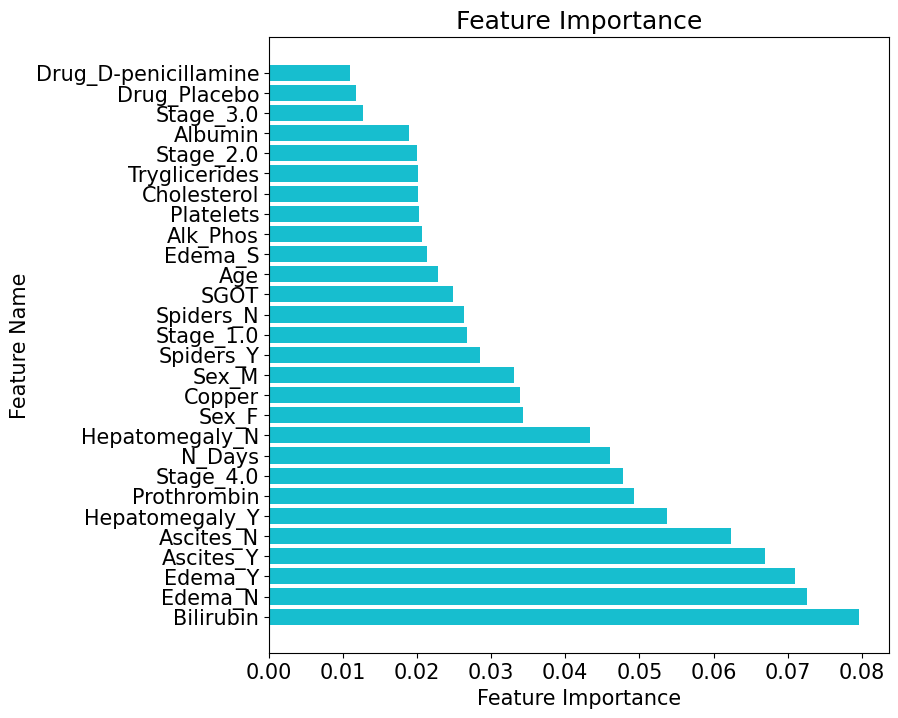

In [70]:
# xgboost model의 각 피쳐 중요도

feature_importances = xgb_model.feature_importances_
feature_names = X.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)
plt.figure(figsize=(8, 8))

plt.barh(sorted_feature_names, sorted_importance_scores, color='#17becf')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.show()

In [37]:
# lightGbM Model 
# StratifiedKFold을 이용한 하이퍼파라미터 최적화 % 모델 학습
# 평가 지표 log_loss

lgbm_params = {'objective': 'multiclass', 
               'max_depth': 5,
               'min_child_samples': 40, 
               'learning_rate': 0.12111533328111715, 
               'n_estimators': 244, 
               'subsample': 0.7979737291502754, 
               'colsample_bytree': 0.4000728186836099, 
               'reg_alpha': 5.810480463845457, 
               'reg_lambda': 9.38438633502167,
               'num_leaves': 20,
               'force_col_wise': True,
               'verbose' : -1,
               'random_state': 2002}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_results = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # lightGbM Model 학습
    lgbm_model = LGBMClassifier(**lgbm_params)
    lgbm_model.fit(X_train,y_train)

    # 검증 데이터셋의 예측
    y_val_pred_prob = lgbm_model.predict_proba(X_val)

    # 모델 평가
    logloss = log_loss(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, Logarithmic Loss on Validation Set: {logloss}')

    # 결과
    cv_results.append(logloss)

# average cross-validation result
average_cv_result = sum(cv_results) / 10
print(f'\nAverage Logarithmic Loss across 10 folds: {average_cv_result}')

Fold 1, Logarithmic Loss on Validation Set: 0.43957561310546667
Fold 2, Logarithmic Loss on Validation Set: 0.4411508131663674
Fold 3, Logarithmic Loss on Validation Set: 0.44650754947583554
Fold 4, Logarithmic Loss on Validation Set: 0.4425029853238683
Fold 5, Logarithmic Loss on Validation Set: 0.3960591935880285
Fold 6, Logarithmic Loss on Validation Set: 0.4249944038991122
Fold 7, Logarithmic Loss on Validation Set: 0.4268422323856527
Fold 8, Logarithmic Loss on Validation Set: 0.4608543639734329
Fold 9, Logarithmic Loss on Validation Set: 0.4395456895090144
Fold 10, Logarithmic Loss on Validation Set: 0.4531705921376425

Average Logarithmic Loss across 10 folds: 0.43712034365644203


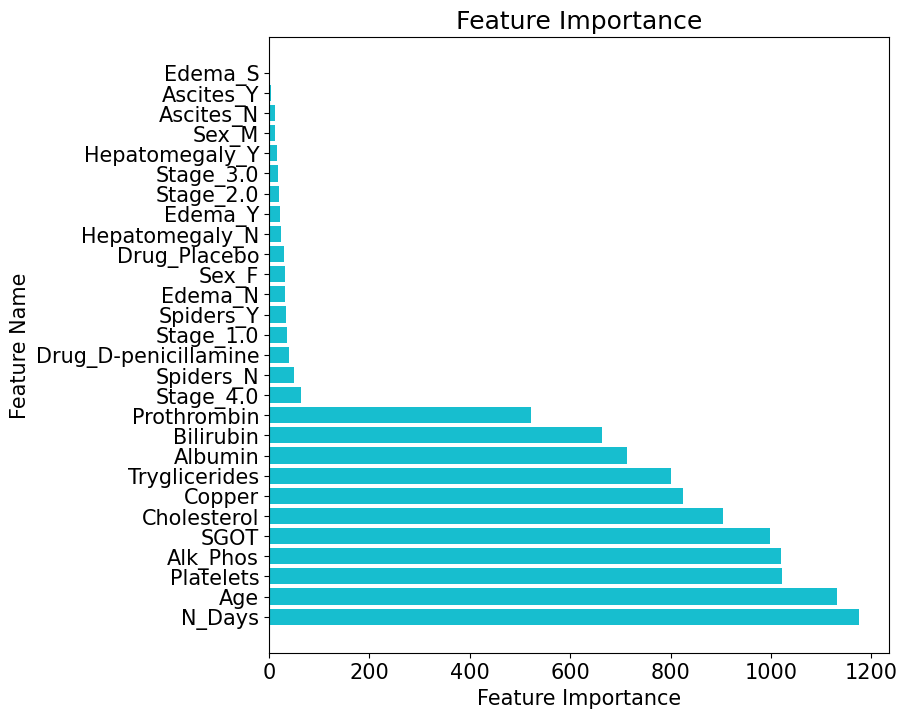

In [69]:
feature_importances = lgbm_model.feature_importances_
feature_names = X.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)
plt.figure(figsize=(8, 8))

plt.barh(sorted_feature_names, sorted_importance_scores, color='#17becf')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.show()

In [39]:
# CatBoost Model
# StratifiedKFold을 이용한 하이퍼파라미터 최적화 & 모델 학습
# 평가 지표 log_loss

catboost_params = {'iterations': 526,
                   'depth': 29, 
                   'min_data_in_leaf': 16,
                   'learning_rate': 0.06594786406828866, 
                   'grow_policy': 'Lossguide',
                   'bootstrap_type' : 'Bernoulli'}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


cv_results = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_model = CatBoostClassifier(**catboost_params, 
                            random_state=2002, verbose =0
                           )
    cat_model.fit(X_train,y_train)

 
    y_val_pred_prob = cat_model.predict_proba(X_val)

    logloss = log_loss(y_val, y_val_pred_prob)
    print(f'Fold {fold + 1}, Logarithmic Loss on Validation Set: {logloss}')

 
    cv_results.append(logloss)

average_cv_result = sum(cv_results) / 10
print(f'\nAverage Logarithmic Loss across 10 folds: {average_cv_result}')

Fold 1, Logarithmic Loss on Validation Set: 0.4410253982738859
Fold 2, Logarithmic Loss on Validation Set: 0.4496134221312931
Fold 3, Logarithmic Loss on Validation Set: 0.4595233796783053
Fold 4, Logarithmic Loss on Validation Set: 0.443412012680566
Fold 5, Logarithmic Loss on Validation Set: 0.4068493295986075
Fold 6, Logarithmic Loss on Validation Set: 0.43990050480366316
Fold 7, Logarithmic Loss on Validation Set: 0.4359058620621937
Fold 8, Logarithmic Loss on Validation Set: 0.45703868941855996
Fold 9, Logarithmic Loss on Validation Set: 0.44882294777539167
Fold 10, Logarithmic Loss on Validation Set: 0.45945515566655715

Average Logarithmic Loss across 10 folds: 0.4441546702089023


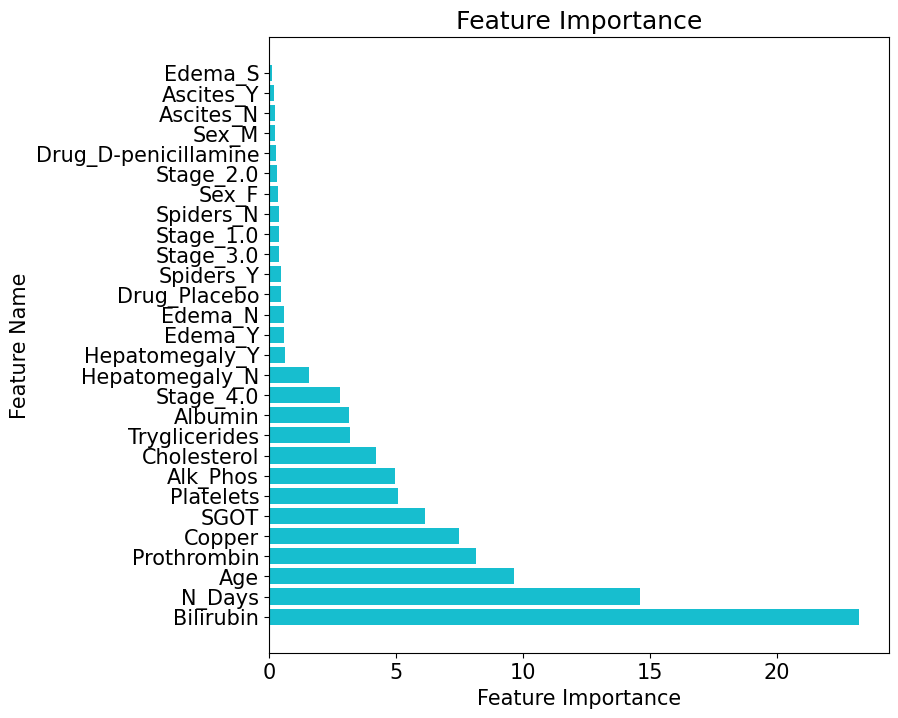

In [71]:
feature_importances = cat_model.feature_importances_
feature_names = X.columns 
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importance_scores = zip(*sorted_feature_importance)
plt.figure(figsize=(8, 8))

plt.barh(sorted_feature_names, sorted_importance_scores, color='#17becf')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance")
plt.show()

## **optuna을 활용한 Hyperparameter Tunning**

In [41]:
'''
def objective_xgb(trial):
     """Define the objective function for XGBClassifier"""

     params = {
         'objective': 'multi:softprob',
         'num_class': 3,  # Assuming 3 classes for multi-class classification
         'max_depth': trial.suggest_int('max_depth', 5, 10),
         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
         'random_state': trial.suggest_categorical('random_state', [2002]),
         'tree_method': 'hist',  # Use GPU for training
         'device' : 'cuda',
         'eval_metric': 'mlogloss',  # Evaluation metric
         'verbosity': 2,  # Set verbosity to 0 for less output
     }

     xgb_model = xgb.XGBClassifier(**params)

     # Assuming 'X_train' and 'y_train' are your training data
     cv = abs(cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='neg_log_loss').mean())
    
     return cv

# Assuming 'skf' is your StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=50)
 
# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Create the final XGBClassifier model with the best parameters
best_xgb_model = xgb.XGBClassifier(**best_params)

# Train the model on the entire dataset
best_xgb_model.fit(X, y)
'''

'\ndef objective_xgb(trial):\n     """Define the objective function for XGBClassifier"""\n\n     params = {\n         \'objective\': \'multi:softprob\',\n         \'num_class\': 3,  # Assuming 3 classes for multi-class classification\n         \'max_depth\': trial.suggest_int(\'max_depth\', 5, 10),\n         \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 10),\n         \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 1.0),\n         \'n_estimators\': trial.suggest_int(\'n_estimators\', 50, 2000),\n         \'subsample\': trial.suggest_float(\'subsample\', 0.01, 1.0),\n         \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.01, 1.0),\n         \'random_state\': trial.suggest_categorical(\'random_state\', [2002]),\n         \'tree_method\': \'hist\',  # Use GPU for training\n         \'device\' : \'cuda\',\n         \'eval_metric\': \'mlogloss\',  # Evaluation metric\n         \'verbosity\': 2,  # Set verbosity to 0 for less output\n   

In [42]:
'''
def objective_lgb(trial):
    params = {
        'objective': trial.suggest_categorical('objective', ['multiclass']),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
    }
    
    lgb_model = lgb.LGBMClassifier(**params)

     # Assuming 'X_train' and 'y_train' are your training data
    cv = abs(cross_val_score(lgb_model, X_train, y_train, cv=10, scoring='neg_log_loss').mean())
    
    return cv

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2002)

study = optuna.create_study(direction='minimize')
study.optimize(objective_lgb, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

best_lgb_model = xgb.XGBClassifier(**best_params)
best_lgb_model.fit(X, y)
'''

'\ndef objective_lgb(trial):\n    params = {\n        \'objective\': trial.suggest_categorical(\'objective\', [\'multiclass\']),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 15),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 50),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.2),\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 200, 1000),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.4, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.4, 1.0),\n        \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0.001, 10.0),\n        \'reg_lambda\': trial.suggest_float(\'reg_lambda\', 0.001, 10.0),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 300),\n    }\n    \n    lgb_model = lgb.LGBMClassifier(**params)\n\n     # Assuming \'X_train\' and \'y_train\' are your training data\n    cv = abs(cross_val_score(lgb_model, X_train, y_train, cv=10, scori

In [43]:
'''

# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

def objective(trial):
     params = {
         'iterations': trial.suggest_int('iterations', 100, 600),
         'depth': trial.suggest_int('depth', 3, 50),
         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
     }
    
     cb_optuna = CatBoostClassifier(**params, random_state=42, grow_policy='Lossguide', verbose=0)

     cv = abs(cross_val_score(cb_optuna, X, y, cv=10, scoring='neg_log_loss').mean())
     return cv

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)
'''

'\n\n# Suppress FutureWarnings related to is_sparse\nwarnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")\n\ndef objective(trial):\n     params = {\n         \'iterations\': trial.suggest_int(\'iterations\', 100, 600),\n         \'depth\': trial.suggest_int(\'depth\', 3, 50),\n         \'min_data_in_leaf\': trial.suggest_int(\'min_data_in_leaf\', 2, 50),\n         \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-4, 0.2, log=True),\n     }\n    \n     cb_optuna = CatBoostClassifier(**params, random_state=42, grow_policy=\'Lossguide\', verbose=0)\n\n     cv = abs(cross_val_score(cb_optuna, X, y, cv=10, scoring=\'neg_log_loss\').mean())\n     return cv\n\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=50)\n\nbest_params = study.best_params\nprint("Best Hyperparameters:", best_params)\n'

In [44]:
# XGBoost, LightGBM, CatBoost Model의 앙상블 모델 학습(VotingClassfier)
from sklearn.ensemble import VotingClassifier

Ensemble = VotingClassifier(estimators = [('lgb', lgbm_model),
                                          ('xgb', xgb_model),
                                          ('CB', cat_model)], voting='soft')
Ensemble.fit(X, y)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(colsample_bytree=0.4000728186836099,
                                             force_col_wise=True,
                                             learning_rate=0.12111533328111715,
                                             max_depth=5, min_child_samples=40,
                                             n_estimators=244, num_leaves=20,
                                             objective='multiclass',
                                             random_state=2002,
                                             reg_alpha=5.810480463845457,
                                             reg_lambda=9.38438633502167,
                                             subsample=0.7979737291502754,
                                             verbose=-1)),
                             ('xgb'...
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=614, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('CB',
                              <catboost.core.CatBoostClassifier object at 0x0000011EF0437B10>)],
                 voting='soft')

In [45]:
# 앙상블 모델을 test_data에 적용해 status 확률 구한 후 submission 파일로 제출

submission["Status_C"] =  Ensemble.predict_proba(test_data)[:,0]
submission["Status_CL"] =  Ensemble.predict_proba(test_data)[:,1]
submission["Status_D"] =  Ensemble.predict_proba(test_data)[:,2]

submission.to_csv('submission.csv',index=False)
submission

,id,Status_C,Status_CL,Status_D
0,7905,0.466225,0.020438,0.513337
1,7906,0.624300,0.203150,0.172550
2,7907,0.033040,0.018713,0.948247
3,7908,0.960496,0.004620,0.034884
4,7909,0.856114,0.044725,0.099161
...,...,...,...,...
5266,13171,0.894680,0.051036,0.054283
5267,13172,0.974275,0.003954,0.021771
5268,13173,0.899475,0.013897,0.086628
5269,13174,0.985102,0.008185,0.006713
